## <font color="green">**_Even MORE Signal Processing_**  

<font color="green"> 
Under the hood, we can access the data as a numpy array. We can design any signal processing routine -- imagination is the only limit!
</font>

In [1]:
#-- Import common packages
import numpy as np
import xdas as xd
import xdas.signal as xs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import xdas.fft as xfft


## <font color="green"> Open the data, different day
<font color="green"> Here, we'll use data from a different day</font>

In [2]:
data = xd.open_mfdataarray('./DAS_Data_Skience2025/Athens/Earthquakes/20210921/*nc')
print(data)

<xdas.DataArray (time: 360000, distance: 12416)>
VirtualStack: 8.3GB (int16)
Coordinates:
  * time (time): 2021-09-21T22:00:00.018 to 2021-09-21T23:59:59.998
  * distance (distance): -264.380 to 25085.858


<font color="green"> There's two hours of data in that folder. Let's look at a subset of it </font>

In [3]:
subset = data.sel(time=slice("2021-09-21T22:00:00", "2021-09-21T22:02:00"),distance=slice(100,20000))
subset = subset * 116.0 / 8192.0 * 400.0 / 10.0 * 1e-9

print(subset)

<xdas.DataArray (time: 6000, distance: 9746)>
[[-1.132813e-08 -1.302734e-08 -1.585938e-08 ... -1.642578e-08
  -1.982422e-08 -2.492188e-08]
 [-1.132813e-08 -1.302734e-08 -1.699219e-08 ... -9.628906e-09
  -2.095703e-08 -1.755859e-08]
 [-1.132813e-08 -1.416016e-08 -1.812500e-08 ...  7.363281e-09
   7.363281e-09  1.076172e-08]
 ...
 [-2.152344e-08 -2.378906e-08 -2.605469e-08 ... -9.062500e-09
  -1.755859e-08 -1.019531e-08]
 [-2.945313e-08 -3.285156e-08 -3.398437e-08 ... -7.929688e-09
  -6.230469e-09 -9.628906e-09]
 [-2.152344e-08 -2.265625e-08 -2.208984e-08 ...  1.189453e-08
   2.152344e-08  1.982422e-08]]
Coordinates:
  * time (time): 2021-09-21T22:00:00.018 to 2021-09-21T22:01:59.998
  * distance (distance): 101.121 to 19999.475


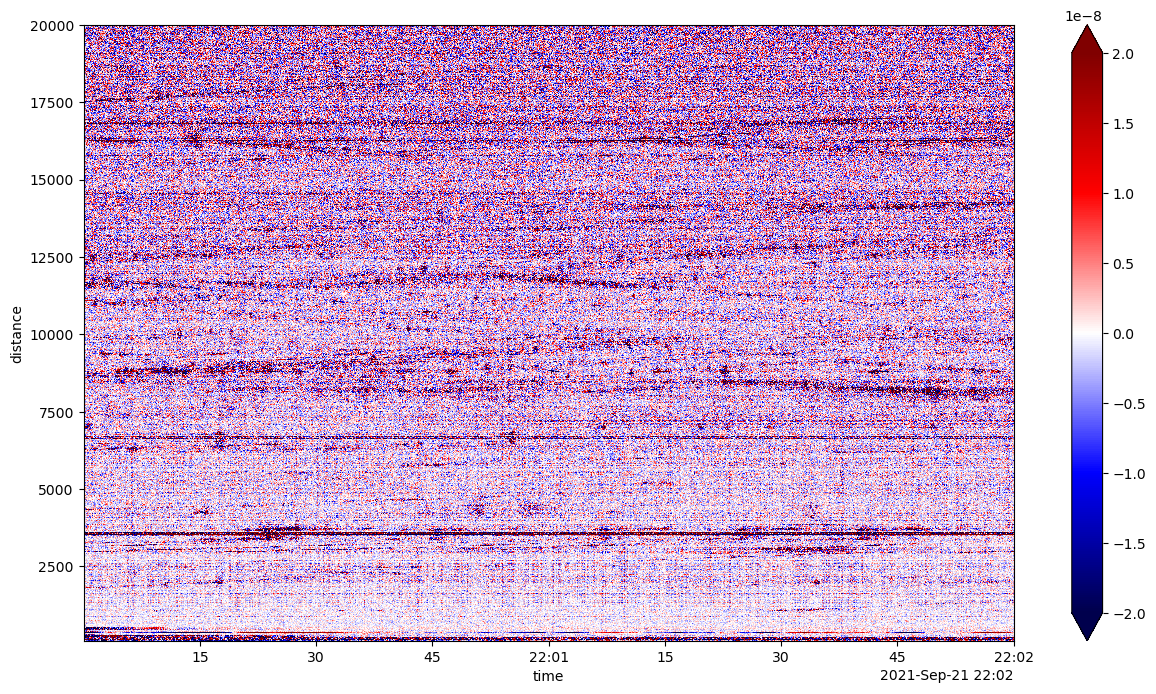

In [4]:
plt.figure(figsize=(15,8))
ax = plt.gca()
subset.plot(x="time",ax=ax,vmin=-20e-9,vmax=20e-9,cmap='seismic') 

<font color="green"></font>

---
## <font color="green">Implement a new function: Phase weighted stack</font>

<font color="green">
One idea is to enhance the coherence of signals arriving on neighboring channels. We might simply average channels. A "rolling average" would mean taking an average of the i_th channel with it's +/- 20 neighboring channels.
</br>

We can take this further, by more strongly weighting the times when those neighboring channels have similar phase. Any signal can be decomposed into an amplitude and phase: 
\begin{equation}
s(t) = A(t)e^{i\phi (t)}
\end{equation}


That separation is achieved with the Hilbert transform, built into numpy, scipy, and XDas. We isolate the phase part by dividing out the $A(t)$, and then average those phases across some channels:

\begin{equation}
c(t) = |\frac{1}{N} \sum_{k=1}^{N}{e^i\phi_k (t)}|
\end{equation}

Finally, we apply that coherence as a "weight" to the averaging:
\begin{equation}
s(t) = \frac{1}{N} \sum_{j=1}^{N}{x_j(t)c^{\nu}(t)}
\end{equation}


</font>


In [5]:
def pws_rolling_average(data,ns,exp=2):

    #-- Empty array of the same shape as data
    data_pws = np.zeros(data.shape)
    nchan = data.shape[1]

    #-- hilbert
    dh = xs.hilbert(data)

    #-- work with straight numpy arrays
    data_np = data.values
    dh = dh.values

    for i in range(ns,nchan-ns-1):
        if(i==ns):
            #-- First iteration: straightforward
            pw = np.mean(dh[:,i-ns:i+ns+1] / np.abs(dh[:,i-ns:i+ns+1]), axis=1)
            av = np.mean(data_np[:,i-ns:i+ns+1], axis=1)
        else:
            #-- subsequently, we make it a bit faster by *not* repeating the averaging every time
            #-- instead, just subtract off one of the previous traces and add the next one.
            pw = pw - (dh[:,i-ns-1] / np.abs(dh[:,i-ns-1])) / (ns*2+1)
            pw = pw + (dh[:,i+ns] / np.abs(dh[:,i+ns])) / (ns*2+1)
            av = av - data_np[:,i-ns-1] / (ns*2+1)
            av = av + data_np[:,i+ns] / (ns*2+1)
        data_pws[:,i] = np.real(pw**exp * av)

    #-- Since data_pws is just a numpy array, let's wrangle it back into XDas format with axis variables.
    data2 = data.copy()
    data2.data = data_pws

    return data2


In [6]:
dpws = pws_rolling_average(subset,ns=10)

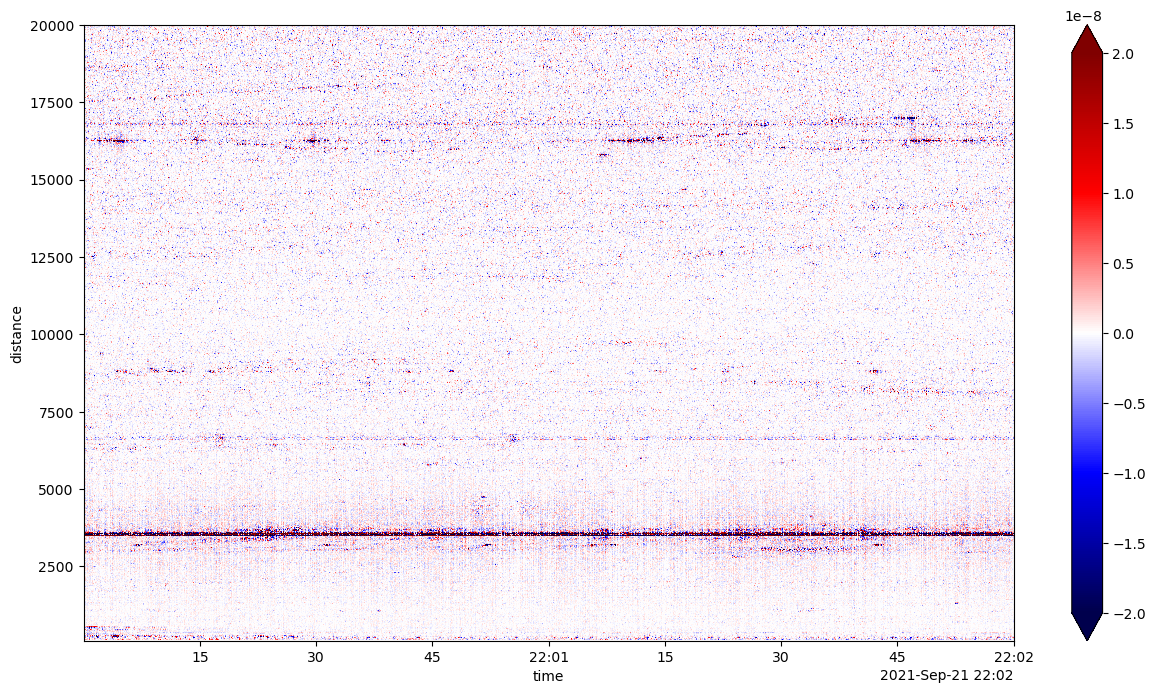

In [7]:
plt.figure(figsize=(15,8))
ax = plt.gca()
dpws.plot(x="time",ax=ax,vmin=-20e-9,vmax=20e-9,cmap='seismic') 

---
## <font color="green">OPSPY!?? Implement OBSPY's STA/LTA</font>

<font color="green">Fully using OBSPY would require wrangling our data into traces and streams. It's possible! ... But here we'll just make use of a couple built-in functions provided by OBSPY, which just happen to work on numpy arrays.

https://docs.obspy.org/tutorial/code_snippets/trigger_tutorial.html

<font color="green"> One common way of detecting earthquakes is the "STA/LTA trigger", which looks at the ratio of Short-Term Average to Long-Term Average. We roll through a seismogram or trace, and if a sudden spike of amplitude appears in the front, short window, relative to the longer trailing window, then it triggers and might be an earthquake. 


</font>


In [8]:
from obspy.signal.trigger import classic_sta_lta, trigger_onset

sample_rate = 50  #Hz

#-- Define lengths of the windows
sta_len = 1  # seconds 
lta_len = 40 # seconds 

#-- Define the ratio that is considered a "Trigger"
#-- The trigger also deactivates or turns off when the ratio drops again
thr_on = 10 #15
thr_off = 1 #1

#-- "cft" will hold the "characteristic function" which just means that ratio
data_np = subset.values
cft_num = np.zeros((np.shape(data_np)))
onoff_num = np.zeros((np.shape(data_np)))

#-- Loop over each trace separately
for num in np.arange(0, np.shape(data_np)[1], 1):

    #-- Compute characteristic function (implement trigger)
    cft = classic_sta_lta(data_np[:,num], sta_len*sample_rate, lta_len*sample_rate)

    #-- Trigger on or off
    tmp_triggers = trigger_onset(cft, thr_on, thr_off)
    for trig in tmp_triggers:
        onoff_num[trig[0]:trig[1],num] = 1                
    
    cft_num[:,num] = cft
    

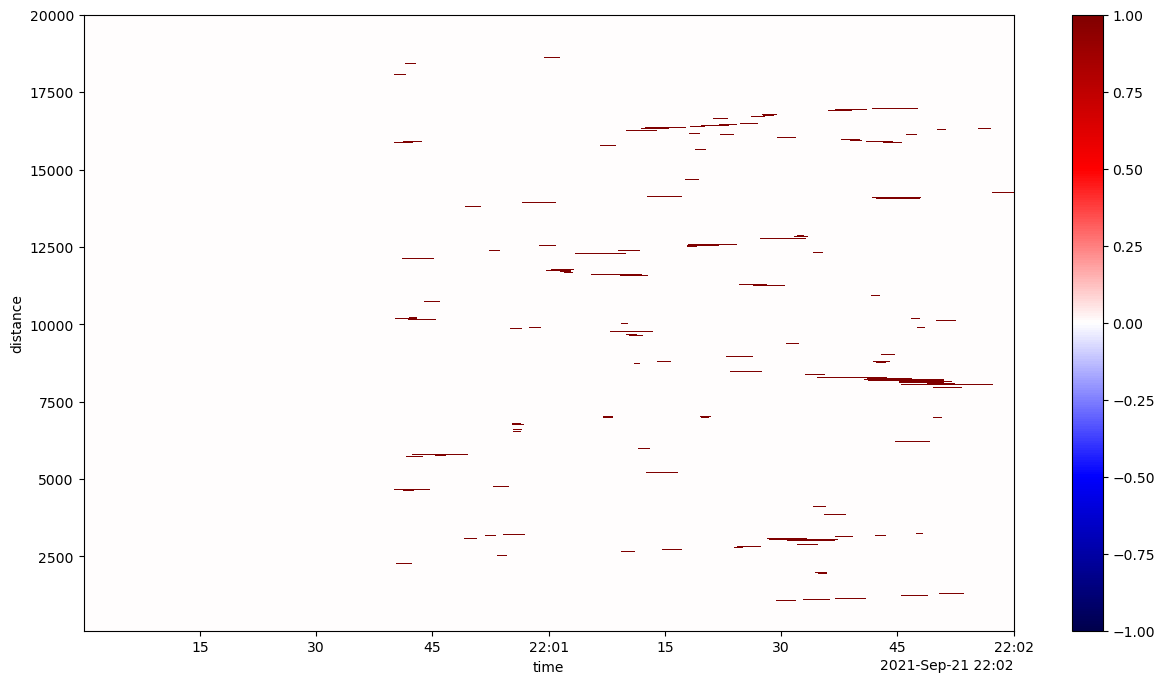

In [9]:
#-- Get back into XDas format
subset_onoff = subset.copy()
subset_onoff.data = onoff_num

#-- Plot
plt.figure(figsize=(15,8))
ax = plt.gca()
subset_onoff.plot(x="time",ax=ax,vmin=-1,vmax=1,cmap='seismic') 

<font color="green">Clearly there's no earthquake here.</font>

---
## <font color="blue"> Exercise: Find the earthquakes!</font> 

#### <font color="blue"> There's at least 2 earthquakes in the two hours of data provided in that folder. Maybe more? Maybe other non-earthquakes?

#### <font color="blue">  Filter it, spectrogram it, STA/LTA it, PWS it - no one knows the optimal workflow. Workshop through the best order and **find** things!

<font color="blue">  If you want to get really fancy, see https://github.com/xdas-dev/tutorials/blob/main/04_massive_atomic_processing.ipynb.
XDas has some nice features built-in that allow for parallel processing of time chunks.
</font>
